In [1]:
import logging
logging.basicConfig(level=logging.INFO)
from IPython.display import display

import numpy as np
from PIL import Image

import torch
import torchvision.models as M
import torchvision.transforms as T

In [2]:
def create_color_palette(N):
    import colorsys

    colorsys.hls_to_rgb(0,1,1)

    import numpy as np

    colors = []
    for hue in np.linspace(0.0,1.0,100):
        color = colorsys.hsv_to_rgb(hue,1,1)
        colors.append(color)

    return np.uint8(np.array(colors)*255)

colors = create_color_palette(100)
np_image = colors.reshape(1, len(colors),3)
Image.fromarray(np_image)

# Segmentation

In [3]:
from  functools import cache

@cache
def getRotoModel()->M.segmentation.FCN:
    '''get segmentation model once'''
    logging.info("get roto model")
    return M.segmentation.deeplabv3_resnet101(weights=M.segmentation.DeepLabV3_ResNet101_Weights.DEFAULT).eval()
    return M.segmentation.fcn_resnet101(weights=M.segmentation.FCN_ResNet101_Weights.DEFAULT).eval()

In [4]:
# Define the helper function
def decode_segmap(np_image:np.array, nc=21)->np.array:
    '''
    Display segmap with visible colors
    '''

    labels = {
        0: "background",
        1: "aeroplane",
        2: "bicycle",
        3: "bird",
        4: "boat",
        5: "bottle",
        6: "bus",
        7: "car",
        8: "cat",
        9: "chair",
        10: "cow",
        11: "dining table",
        12: "dog",
        13:"horse",
        14:"motorbike",
        15:"person",
        16:"potted plant",
        17:"sheep",
        18:"sofa",
        19:"train",
        20:"tv/monitor"
    }

    label_colors = create_color_palette( len(labels) )
    label_colors[0]= (0,0,0) # set backgroubnd to black

    r = np.zeros_like(np_image).astype(np.uint8)
    g = np.zeros_like(np_image).astype(np.uint8)
    b = np.zeros_like(np_image).astype(np.uint8)

    for label_id, color in enumerate(label_colors):
        label_mask = np_image == label_id
        r[label_mask] = label_colors[label_id, 0]
        g[label_mask] = label_colors[label_id, 1]
        b[label_mask] = label_colors[label_id, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def createMatte(img):

    # preprocess image
    logging.info("preprocess iamge")
    preprocess = T.Compose([
                T.Resize(img.size),
                T.ToTensor(), 
                T.Normalize(mean = [0.485, 0.456, 0.406], 
                            std = [0.229, 0.224, 0.225])
                ])
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)

    # fetch rotomodel once
    logging.info("fetch roto model from cache")
    model = getRotoModel()
    
    # segment image with model
    logging.info(f"segmenting image... ({img.size[0]}x{img.size[1]})")
    with torch.no_grad():
        out_tensor = model(input_batch)['out'][0]
    output_predictions = out_tensor.argmax(0) #torch.argmax(out_tensor.squeeze(), dim=0).detach().cpu().numpy()

    # visualize segmap
    logging.info("visualize segmap...")
    rgb = decode_segmap(output_predictions)
    im = Image.fromarray(rgb)
    return im

## Single Image

INFO:root:preprocess iamge
INFO:root:fetch roto model from cache
INFO:root:get roto model
INFO:root:segmenting image... (512x512)
INFO:root:visualize segmap...


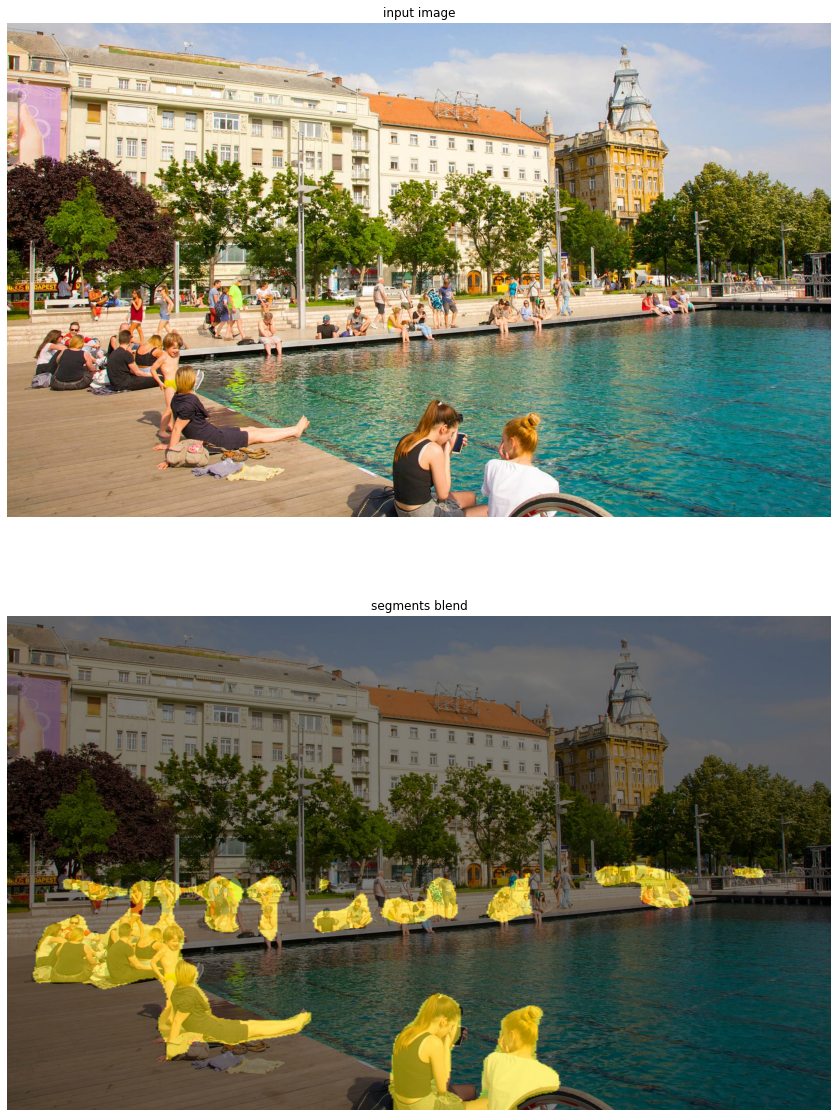

In [5]:
from src.PathSequence import PathSequence
import matplotlib.pyplot as plt
f, ax = plt.subplots(2, 1, figsize=(20, 20))
ax[0].set_title('input image')
ax[0].axis('off')
ax[1].set_title('segments blend')
ax[1].axis('off')

try:
    filename = "E:/Mesterjatszma/Proxy/A043C011/A043C011.0409.jpg"
    filename = "R:/Mesterjatszma/Proxy/A043C009_211119_R33P/A043C009_211119_R33P_01061.jgg"
    input_img = Image.open(filename)
except FileNotFoundError:
    import requests
    url = "https://images.contentstack.io/v3/assets/blt00454ccee8f8fe6b/bltf8a72260189be996/60ab28704adeb65c03d761d4/UK_Budapest_Hungary_Header.jpg?width=1680&quality=70&auto=webp"
    input_img = Image.open(requests.get(url, stream=True).raw)

ax[0].imshow(input_img)
#img = img.crop( (780, 0, 780+1024, 1024) )
input_img.convert("RGB")
segmentation = createMatte(input_img.resize( (512,512) )).resize(input_img.size)

Image.blend(input_img, segmentation, 0.5)
ax[1].imshow( Image.blend(input_img, segmentation, 0.5) )
plt.show()
